In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### Download the data for training and validation

In [2]:
training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

### Iterating and Visulaising the Dataset

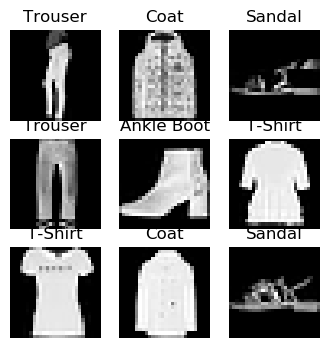

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(4,4)) # size of plotted images
cols, rows = 3,3 # layout of plotted images

# loop over 10 (not inclusive) images in the dataset 
for i in range(1, cols*rows +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # return random integer 
    img, label = training_data[sample_idx] # get image at random index
    figure.add_subplot(rows,cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()
        

### Create a Custom Dataset for your files

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

In [6]:
class CustomImageDataset(Dataset):
    
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

### Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader
We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


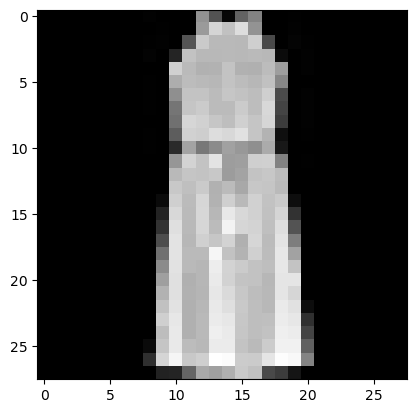

label: 3


In [10]:
# display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'label: {label}')

### TRANSFORMS
Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.

In [14]:
from torchvision.transforms import Lambda

ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# the lambda function applies to each recored when it is loaded by the dataloader,
# so whatever the "y" value of that record, it will be one-hot encoded

### ToTensor()
ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

### Lambda Transforms
Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

### BUILD THE NEURAL NETWORK
Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In the following sections, we’ll build a neural network to classify images in the FashionMNIST dataset.

In [17]:
from torch import nn
from torchvision import datasets, transforms

### Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU or MPS, if available. Let’s check to see if torch.cuda or torch.backends.mps are available, otherwise we use the CPU.

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Define the Class
We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [22]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x): # called by pytorch when data is passed to the model
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of NeuralNetwork, and move it to the device, and print its structure.



In [23]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [27]:
X = torch.rand(1,28,28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([6])


In [28]:
pred_probab

tensor([[0.1016, 0.1119, 0.0948, 0.1176, 0.1002, 0.1059, 0.1180, 0.0849, 0.0855,
         0.0796]], grad_fn=<SoftmaxBackward0>)

### Model Layers
Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [29]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten
We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

In [31]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])
